# MS028 Preprocess
Created: 01/29/2024 \
Updated: 09/13/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS028'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09142024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw/MS028_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2194047  =      0.000 ...  2142.624 secs...


In [8]:
mne_data

<RawEDF | MS028_SWB.edf, 276 x 2194048 (2142.6 s), ~4.51 GB, data loaded>

In [8]:
# mne_data.ch_names

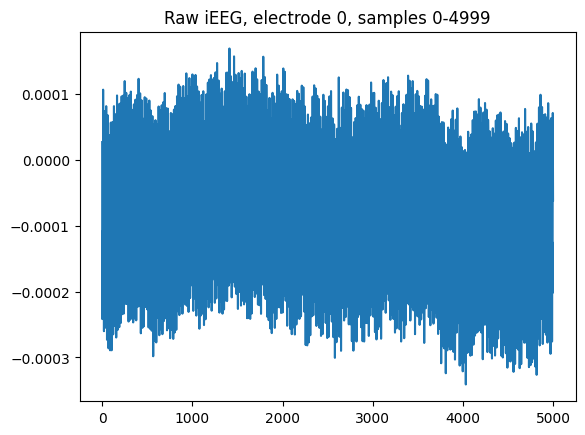

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.5min finished


<RawEDF | MS028_SWB.edf, 276 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.3s finished


<RawEDF | MS028_SWB.edf, 276 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Photodiode
- examine photodiode 

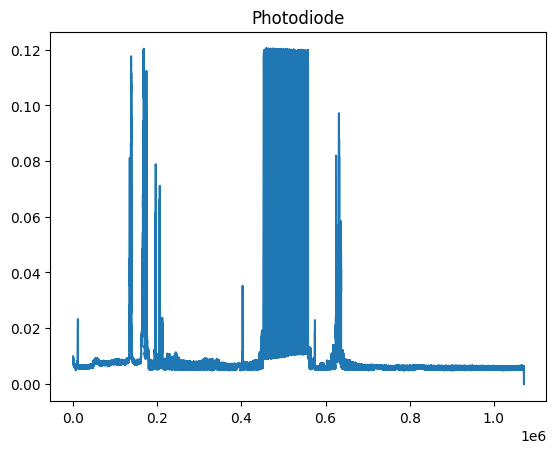

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LAglT1,mAmyg_L,-22.353151,11.990105,-12.842655,-24.030008,-2.466548,-21.004349,Gray,Left Amygdala,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
1,LAglT2,lAmyg_L,-27.152578,11.990105,-11.243587,-29.338226,-2.282588,-19.243495,Gray,Left Ent entorhinal area,Amygdala (LB),L Amygdala,L Amyg,Left amygdala superior,NaN,NaN
2,LAglT3,Unknown,-31.952006,12.389775,-10.044287,-34.646184,-1.732659,-18.001756,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LAglT4,vId/vIg_L,-36.751433,12.389775,-8.445219,-39.885009,-1.486931,-16.129432,Gray,Left PIns posterior insula,Area Id1,L Superior Temporal Gyrus,L INS,Left superior temporal gyrus A,NaN,NaN
4,LAglT5,A38l_L,-41.550861,12.789446,-7.245918,-45.108698,-0.767422,-14.632926,Gray,Left PP planum polare,Unknown,L Superior Temporal Gyrus,L STG,Left superior temporal gyrus A,NaN,Borderline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,RmOlF9,A44op_R,35.639932,35.170976,11.942894,39.015475,30.366030,0.328881,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Triangularis),R IFG,Right anterior pars triangularis B,NaN,NaN
162,uLAglT,rHipp_L,-17.953676,11.190765,-14.041956,-19.136886,-3.331668,-22.148985,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN,NaN
163,uLmOlF,A13_L,-7.554916,38.768008,-10.044287,-8.831674,27.220768,-22.979829,Gray,Left GRe gyrus rectus,Area Fo2,L Rectal Gyrus,L OrG,Left frontal orbital 5 A,NaN,NaN
164,uRAglT,mAmyg_R,18.042031,7.993403,-12.043121,19.030036,-5.166208,-20.077131,Gray,Right Amygdala,Amygdala (SF),R ParaHippocampal Gyrus,R Amyg,Right amygdala superior,NaN,NaN


In [17]:
list(elec_locs.label)

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMmM1',
 'LCMmM10',
 'LCMmM11',
 'LCMmM12',
 'LCMmM13',
 'LCMmM14',
 'LCMmM2',
 'LCMmM3',
 'LCMmM4',
 'LCMmM5',
 'LCMmM6',
 'LCMmM7',
 'LCMmM8',
 'LCMmM9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaIpS1',
 'LaIpS10',
 'LaIpS11',
 'LaIpS12',
 'LaIpS13',
 'LaIpS14',
 'LaIpS15',
 'LaIpS16',
 'LaIpS2',
 'LaIpS3',
 'LaIpS4',
 'LaIpS5',
 'LaIpS6',
 'LaIpS7',
 'LaIpS8',
 'LaIpS9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RC

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lalps1', 'lalps2', 'lalps3', 'lalps4', 'lalps5', 'lalps6', 'lalps7', 'lalps8', 'lalps9', 'lalps10', 'lalps11', 'lalps12', 'lalps13', 'lalps14', 'lalps15', 'lalps16', 'c63', 'c64', 'rlms1', 'rlms2', 'rlms3', 'rlms4', 'rlms5', 'rlms6', 'rlms7', 'rlms8', 'rlms9', 'rlms10', 'rlms11', 'rlms12', 'rlms13', 'rlms14', 'rlms15', 'rlms16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c2

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lcmmm1': 'lcmmm1',
 'lcmmm2': 'lcmmm2',
 'lcmmm3': 'lcmmm3',
 'lcmmm4': 'lcmmm4',
 'lcmmm5': 'lcmmm5',
 'lcmmm6': 'lcmmm6',
 'lcmmm7': 'lcmmm7',
 'lcmmm8': 'lcmmm8',
 'lcmmm9': 'lcmmm9',
 'lcmmm10': 'lcmmm10',
 'lcmmm11': 'lcmmm11',
 'lcmmm12': 'lcmmm12',
 'lcmmm13': 'lcmmm13',
 'lcmmm14': 'lcmmm14',
 'rcmmm1': 'rcmmm1',
 'rcmmm2': 'rcmmm2',
 'rcmmm3': 'rcmmm3',
 'rcmmm4': 'rcmmm4',
 'rcmmm5': 'rcmmm5',
 'rcmmm6': 'rcmmm6',
 'rcmmm7': 'rcmmm7',
 'rcmmm8': 'rcmmm8',
 'rcmmm9': 'rcmmm9',
 'rcmmm10': 'rcmmm10',
 'rcmmm11': 'rcmmm11',
 'rcmmm12': 'rcmmm12',
 'rcmmm13': 'rcmmm13',
 'rcmmm14': 'rcmmm14',
 'lalps1': 'la

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 80 left sEEG and 82 right sEEG electrodes
We have a total of 162 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS028_SWB.edf, 275 x 1071312 (2142.6 s), ~2.20 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS028_SWB.edf, 162 x 1071312 (2142.6 s), ~1.29 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS028_SWB.edf, 162 x 1071312 (2142.6 s), ~1.29 GB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'laips': 16,
 'lcmmm': 14,
 'lhplt': 10,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmmm': 14,
 'rhplt': 10,
 'rims': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [31]:
# # mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [32]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/50)


In [33]:
# mne_data.info['bads'] = ['rmolf8',
#  'rmolf9',
#  'lcmmm11',
#  'lmolf3',
#  'lmolf4',
#  'lmolf5',
#  'lmolf6',
#  'lmolf7',
#  'lmolf9',
#  'lcmmm1',
#  'lcmmm2',
#  'lcmmm3',
#  'lcmmm4',
#  'lcmmm5',
#  'rcmmm1',
#  'rcmmm2',
#  'rcmmm3',
#  'rcmmm4',
#  'rcmmm5',
#  'rcmmm6',
#  'rcmmm7',
#  'rcmmm8',
#  'rcmmm9',
#  'laips3',
#  'laips4',
#  'laips5',
#  'laips6',
#  'laips7',
#  'laips8',
#  'laips9',
#  'raglt8',
#  'lhplt9',
#  'lhplt10']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [31]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [48]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/raw_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...


### Bipolar Re-ref

In [49]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=103, n_times=1071312
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Added the following bipolar channels:
laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, lcmmm1-lcmmm2, lcmmm2-lcmmm3, lcmmm3-lcmmm4, lcmmm4-lcmmm5, lcmmm5-lcmmm6, lcmmm12-lcmmm13, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lhplt8-lhplt9, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas8-lacas9, laips1-laips2, laips2-laips3, laips3-laips4, laips4-laips5, laips8-laips9, laips9-laips10, laips10-laips11, laips11-laips12, laips12-laips13, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms6, lmcms6-lmcms7, lmcms8-lmcms9, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf6-lmolf7, lmolf7-lmolf8

In [50]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 103 x 1071312 (2142.6 s), ~842.0 MB, data loaded>

In [51]:
mne_data_bp_reref.ch_names

['laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'lcmmm1-lcmmm2',
 'lcmmm2-lcmmm3',
 'lcmmm3-lcmmm4',
 'lcmmm4-lcmmm5',
 'lcmmm5-lcmmm6',
 'lcmmm12-lcmmm13',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas8-lacas9',
 'laips1-laips2',
 'laips2-laips3',
 'laips3-laips4',
 'laips4-laips5',
 'laips8-laips9',
 'laips9-laips10',
 'laips10-laips11',
 'laips11-laips12',
 'laips12-laips13',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms6',
 'lmcms6-lmcms7',
 'lmcms8-lmcms9',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt4-raglt5',
 'raglt5-raglt6',
 'raglt6-raglt7',
 'raglt7-raglt8',
 'rcmmm1-rcmmm2',
 'rcmmm2-rcmmm3',
 'rcmmm3-rcmmm4',
 

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

<IPython.core.display.Javascript object>


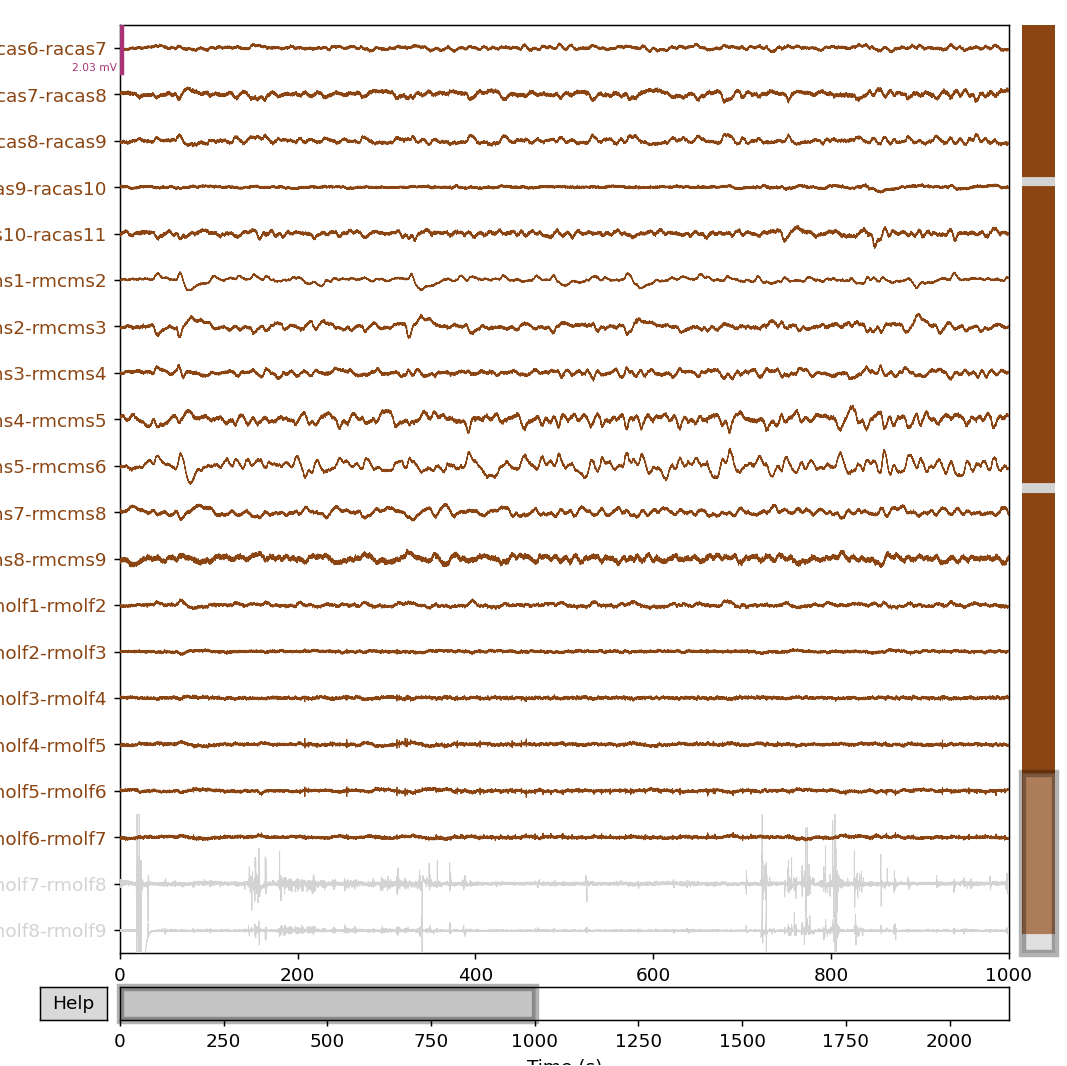

In [102]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=20, scalings=mne_data_bp_reref._data.max()/20)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


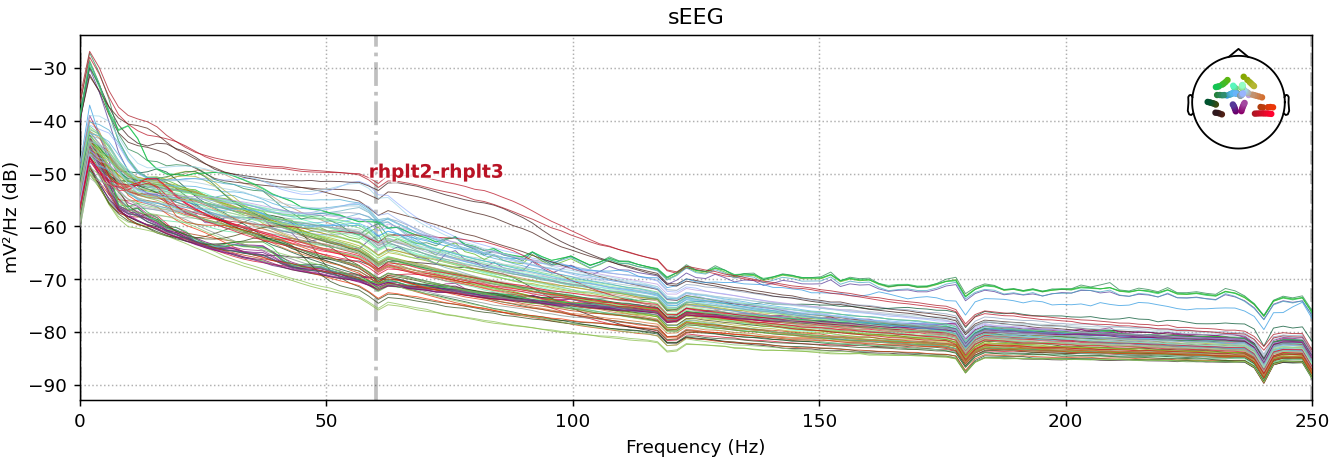

<IPython.core.display.Javascript object>


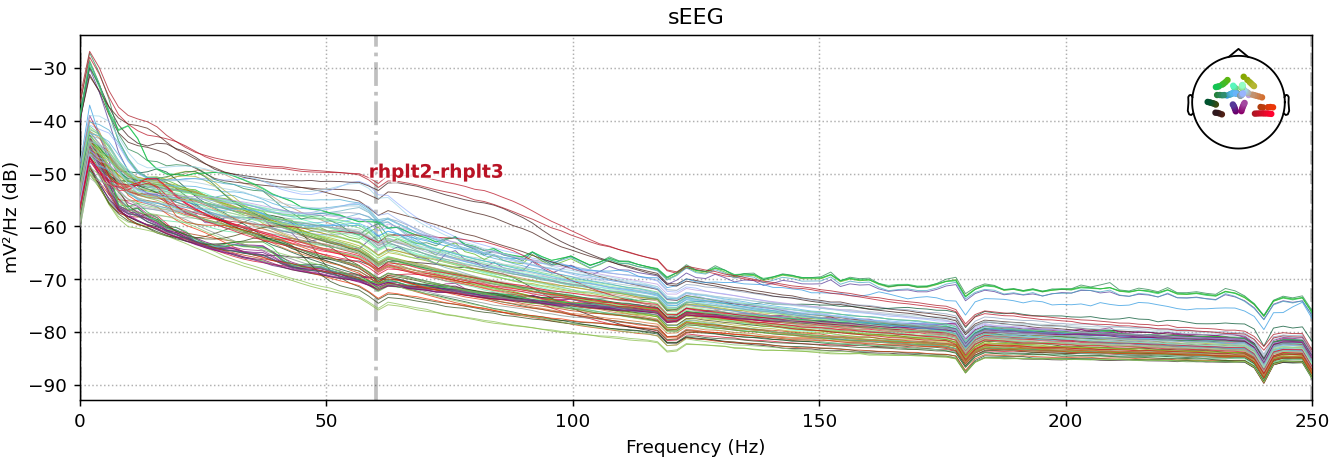

In [100]:
 %matplotlib notebook
mne_data_bp_reref.compute_psd().plot()

In [ ]:
# mne_data_bp_reref.compute_psd().plot()

In [56]:
print(mne_data_bp_reref.info['bads'],date)

['lhplt8-lhplt9', 'raglt7-raglt8', 'rmolf7-rmolf8', 'rmolf8-rmolf9'] 05212024


## Save Reref Data

In [57]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif
[done]


In [118]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [7]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,147.0,loss,415.248181,415.261651,418.478325,418.486410,3.216674,-0.6,-1.90,...,1.30,1.30,0.00,0.0,1.30,1.30,-1.90,-1.90,0.000,0.000
1,2,49.0,mix,425.428719,425.429475,427.623831,429.640132,2.194356,0.0,-1.50,...,3.75,2.25,0.00,0.0,3.75,2.25,-1.50,0.00,1.875,0.000
2,3,104.0,loss,434.667298,434.668050,438.568198,438.573047,3.900148,-0.2,-0.44,...,-0.20,-0.20,-0.20,-0.2,0.00,0.00,0.00,0.00,0.000,0.000
3,4,77.0,gain,448.180423,448.181139,449.778751,451.794099,1.597613,0.4,0.00,...,1.26,0.86,0.00,0.0,1.26,0.86,0.00,0.40,0.630,0.000
4,5,75.0,gain,455.882891,455.889917,458.640682,460.657221,2.750766,0.4,0.00,...,0.99,0.59,0.00,0.0,0.99,0.59,0.00,0.40,0.495,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,41.0,mix,2066.566243,2066.573045,2068.188452,2070.205437,1.615407,0.0,-0.80,...,-1.76,-0.80,-1.76,-0.8,0.00,0.00,0.96,0.00,0.000,-0.880
146,147,116.0,loss,2075.402618,2075.409942,2079.715767,2079.723540,4.305825,-0.3,-0.84,...,0.54,0.54,0.00,0.0,0.54,0.54,-0.84,-0.84,0.000,0.000
147,148,85.0,gain,2089.111040,2089.117723,2090.110714,2092.126862,0.992990,0.5,0.00,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.000
148,149,95.0,gain,2096.835060,2096.841660,2097.805971,2099.822997,0.964311,0.6,0.00,...,-1.49,-0.60,-1.49,-0.6,0.00,0.00,1.49,0.60,0.000,-0.745


In [8]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/photodiode.fif...
Isotrak not found
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...


In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1071312 (2142.6 s), ~8.2 MB, data loaded>

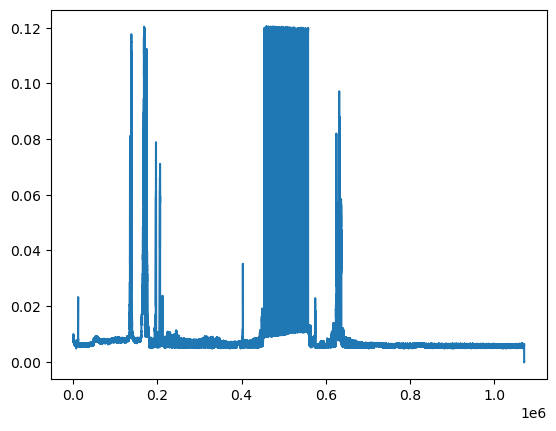

In [10]:
%matplotlib inline
plt.plot(photodiode_data._data[0,:])
plt.show()

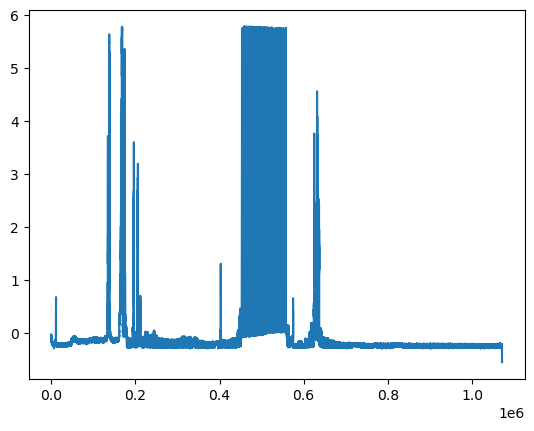

In [11]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()


In [12]:
### Photodiode alignment
smoothSize=11
windSize=15
height=3.5


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

2 blocks
..

found matches for 15 of 32 pulses


In [13]:
print(slope, offset,smoothSize,windSize,height)

0.9896182292570862 12.238687966053362 11 15 3.5


In [14]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [15]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

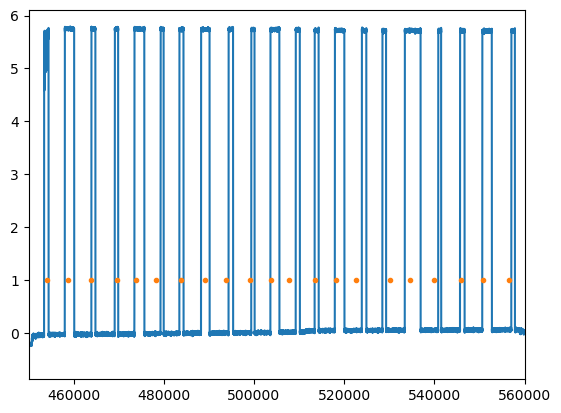

In [16]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq), '.')

plt.xlim([450000,560000])
plt.show()

### INVERTED!

In [17]:
temp_diode = photodiode_data.copy()
temp_diode._data = -temp_diode._data
# temp_data = temp_diode._data[0,:]
# temp_diode._data[temp_diode._data>0.8] = -2
# temp_diode._data[0,0:400000] = np.min(temp_diode._data)
# temp_diode._data[0,600000:] = np.min(temp_diode._data)


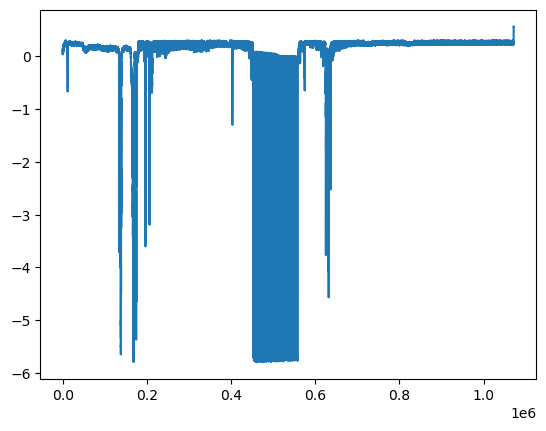

In [18]:
plt.plot(zscore(temp_diode._data[0,:]))
# plt.xlim([450000,560000])
plt.show()

In [19]:
### Photodiode alignment
smoothSize=11
windSize=15
height=-1.5


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

3 blocks
...

found matches for 15 of 58 pulses


In [20]:
print(slope, offset,smoothSize,windSize,height)

0.9999999266226504 14.739439002711151 11 15 -1.5


In [21]:
### Photodiode alignment# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 


150

In [22]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

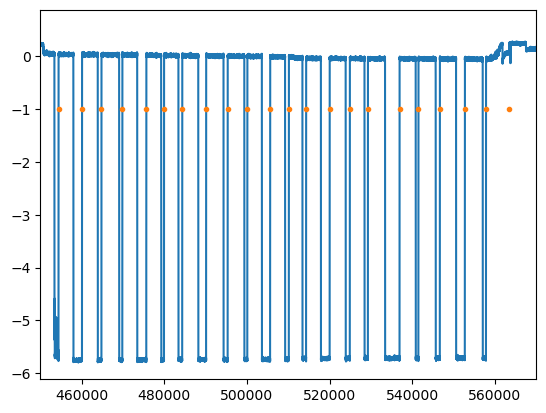

In [23]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-2, '.')

plt.xlim([450000,570000])
plt.show()


In [24]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [25]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([ 0.99999993, 14.739439  ])

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [119]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,147.0,loss,415.248181,415.261651,418.478325,418.486410,3.216674,-0.6,-1.90,...,1.30,1.30,0.00,0.0,1.30,1.30,-1.90,-1.90,0.000,0.000
1,2,49.0,mix,425.428719,425.429475,427.623831,429.640132,2.194356,0.0,-1.50,...,3.75,2.25,0.00,0.0,3.75,2.25,-1.50,0.00,1.875,0.000
2,3,104.0,loss,434.667298,434.668050,438.568198,438.573047,3.900148,-0.2,-0.44,...,-0.20,-0.20,-0.20,-0.2,0.00,0.00,0.00,0.00,0.000,0.000
3,4,77.0,gain,448.180423,448.181139,449.778751,451.794099,1.597613,0.4,0.00,...,1.26,0.86,0.00,0.0,1.26,0.86,0.00,0.40,0.630,0.000
4,5,75.0,gain,455.882891,455.889917,458.640682,460.657221,2.750766,0.4,0.00,...,0.99,0.59,0.00,0.0,0.99,0.59,0.00,0.40,0.495,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,41.0,mix,2066.566243,2066.573045,2068.188452,2070.205437,1.615407,0.0,-0.80,...,-1.76,-0.80,-1.76,-0.8,0.00,0.00,0.96,0.00,0.000,-0.880
146,147,116.0,loss,2075.402618,2075.409942,2079.715767,2079.723540,4.305825,-0.3,-0.84,...,0.54,0.54,0.00,0.0,0.54,0.54,-0.84,-0.84,0.000,0.000
147,148,85.0,gain,2089.111040,2089.117723,2090.110714,2092.126862,0.992990,0.5,0.00,...,1.24,0.74,0.00,0.0,1.24,0.74,0.00,0.50,0.620,0.000
148,149,95.0,gain,2096.835060,2096.841660,2097.805971,2099.822997,0.964311,0.6,0.00,...,-1.49,-0.60,-1.49,-0.6,0.00,0.00,1.49,0.60,0.000,-0.745


In [120]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 418.47832469968125, 418.4864101996645),
 ('gamble', 427.6238307999447, 429.64013219997287),
 ('safe', 438.5681980000809, 438.5730471001007),
 ('gamble', 449.7787512997165, 451.7940989998169),
 ('gamble', 458.6406820998527, 460.6572211999446),
 ('gamble', 467.5526966997422, 469.5688841999509),
 ('safe', 480.5958094997332, 480.6029832996428),
 ('gamble', 491.4062816998921, 493.4228892000392),
 ('safe', 502.76696599973366, 502.7748924996704),
 ('safe', 515.5935164997354, 515.6014065998606),
 ('gamble', 524.3221396999434, 526.339086199645),
 ('gamble', 534.1669275998138, 536.1838076999411),
 ('gamble', 545.044998199679, 547.0614674999379),
 ('gamble', 552.5238818996586, 554.5405700998381),
 ('gamble', 561.3363194996491, 563.35275359964),
 ('safe', 574.095852300059, 574.1028399998322),
 ('safe', 582.7750649997033, 582.7797237997875),
 ('gamble', 591.570272800047, 593.5865907999687),
 ('gamble', 604.4969596997835, 606.5133881000802),
 ('gamble', 613.075704799965, 615.0918409000151)

In [121]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       420.478325
1       429.623831
2       440.568198
3       451.778751
4       460.640682
          ...     
145    2070.188452
146    2081.715767
147    2092.110714
148    2099.805971
149    2109.151152
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [122]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [123]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [124]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [125]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    9.2s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   13.1s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS028/bp_ref_ieeg.fif...
    Range : 0 ... 1071311 =      0.000 ...  2142.622 secs
Ready.
Reading 0 ... 1071311  =      0.000 ...  2142.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   13.1s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [126]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~177.1 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~147.6 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~295.0 MB, data loaded,
  'CpeOnset': 150>}

In [127]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [128]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [129]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [130]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [131]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~177.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~147.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~295.0 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [132]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [133]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [134]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   51.1s finished


Adding metadata with 19 columns


In [135]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 99, ~1.66 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [136]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   37.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.5min finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns


In [137]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 99, ~853.3 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 99, ~4.98 GB>}

In [138]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 99, ~853.3 MB>

In [139]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 99, ~4.98 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [140]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 14.739439002711151


In [141]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
